In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

plt.style.use('ggplot')

# Preprocessing

In [104]:
# Importing data and defining colors
df = pd.read_csv('2021MCMProblemC_DataSet.csv')
classes = ['Positive ID', 'Negative ID', 'Unverified', 'Unprocessed']
colors = [['orange', 'teal', 'tab:pink', 'tab:brown'], ['red', 'blue', 'tab:purple', 'brown']]

# Removing positive and negative cases for binary classification
df_negative = df.loc[df['Lab Status'] == 'Negative ID']
df_positive = df.loc[df['Lab Status'] == 'Positive ID']
df_negative['Label'] = 0
df_positive['Label'] = 1
df = pd.concat([df_negative, df_positive])

# Labeling Insects as features
df_lab = df[['Notes', 'Lab Comments']] 
df_lab = df_lab.applymap(lambda s:s.lower() if type(s) == str else s)

# Separate the most common mistakes and label them as a class
df_digger = df_lab[df_lab['Lab Comments'].str.contains('digger', na=False)]
df_horntail = df_lab[df_lab['Lab Comments'].str.contains('horntail', na=False)]
df_sawfly = df_lab[df_lab['Lab Comments'].str.contains('sawfly', na=False)]
df_cicada = df_lab[df_lab['Lab Comments'].str.contains('cicada', na=False)]
df_wasp = df_lab[df_lab['Lab Comments'].str.contains('wasp', na=False)]

In [105]:

print(df.head())

# Replacing values
df_digger['GD'] = 1
df_horntail['Hor'] = 1
df_sawfly['Saw'] = 1
df_cicada['Cic'] = 1

df = pd.merge(df, df_digger['GD'], how='outer',  left_index=True, right_index=True)
df = pd.merge(df, df_horntail['Hor'], how='outer',  left_index=True, right_index=True)
df = pd.merge(df, df_sawfly['Saw'], how='outer',  left_index=True, right_index=True)
df = pd.merge(df, df_cicada['Cic'], how='outer',  left_index=True, right_index=True)

# # ============= feature engineer with common words?? ==============
df['Detection Date'] = pd.to_datetime(df['Detection Date'], errors = 'coerce')
df['Submission Date'] = pd.to_datetime(df['Submission Date'], errors = 'coerce')
df['D_Day'] = df['Detection Date'].dt.day
df['D_Month'] = df['Detection Date'].dt.month
df['D_Year'] = df['Detection Date'].dt.year
df['S_Day'] = df['Submission Date'].dt.day
df['S_Month'] = df['Submission Date'].dt.month
df['S_Year'] = df['Submission Date'].dt.year

# # Create y set and remove unnessary features
y = pd.DataFrame(df['Label'], columns=['Label'])
df = df.drop(['GlobalID', 'Lab Status', 'Lab Comments', 'Detection Date', 'Submission Date', 'Label'], axis=1)

                                  GlobalID Detection Date  \
6   {C4F44511-EA53-4FCF-9422-E1C57703720D}      2/29/2020   
8   {89C867F1-D5ED-48C8-9586-B705F5DA9838}       9/7/2019   
9   {81670D96-4143-47B1-A9C8-83977892D53F}      3/19/2020   
12  {D30895B7-3994-45A3-BD51-E5BA881833FD}      8/30/2019   
14  {1304CF55-4FF9-490F-AF5A-5719CD110A9D}      3/23/2020   

                                                Notes   Lab Status  \
6   I’m not sure what this is, but it was the bigg...  Negative ID   
8   slow moving, i have this in the freezer still ...  Negative ID   
9   It landed on my window while working. It walke...  Negative ID   
12  Probably not an Asain Hornet but still a prett...  Negative ID   
14  Was on the garden hose. It stung (maybe just a...  Negative ID   

                                         Lab Comments Submission Date  \
6   This is a large fly that mimics bees! Thanks f...       2/29/2020   
8   Thank you for this submission. This is a harml...       3/18/2

In [106]:
df = df.fillna(0)
df.head()

,Notes,Latitude,Longitude,GD,Hor,Saw,Cic,D_Day,D_Month,D_Year,S_Day,S_Month,S_Year
0,"One dead wasp seen in Blaine, and suspect flyi...",48.980994,-122.688503,0.0,0.0,0.0,0.0,8.0,12.0,2019.0,15,1,2020
1,Hornet specimen sent to WSU,48.971949,-122.700941,0.0,0.0,0.0,0.0,30.0,10.0,2019.0,15,1,2020
3,This was the colony that was found and destroy...,49.149394,-123.943134,0.0,0.0,0.0,0.0,19.0,9.0,2019.0,4,2,2020
6,"I’m not sure what this is, but it was the bigg...",48.729596,-122.480035,0.0,0.0,0.0,0.0,29.0,2.0,2020.0,29,2,2020
8,"slow moving, i have this in the freezer still ...",47.395721,-123.105188,1.0,0.0,0.0,0.0,7.0,9.0,2019.0,18,3,2020


In [128]:
y

,Label
0,1
1,1
3,1
6,0
8,0
9,0
12,0
14,0
18,0
19,0


## Vectorizing Words

In [108]:
# Vectorize Descriptions from users
vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(df['Notes'])

In [109]:
df = df.drop(['Notes'], axis=1)
df = np.array(df)
print(df)
words = vectorizer.get_feature_names()
words.extend(('Latitude','Longitude', 'GD','Hor', 'Saw', 'Cic', 'D_Day', 'D_Month', 'D_Year', 'S_Day', 'S_Month', 'S_Year'))
X = np.concatenate([word_matrix.toarray(), df], axis=1)
df = pd.DataFrame(X, columns=words)

df.head()
# df.head(5).to_latex(index=False)

[[ 4.89809940e+01 -1.22688503e+02  0.00000000e+00 ...  1.50000000e+01
   1.00000000e+00  2.02000000e+03]
 [ 4.89719490e+01 -1.22700941e+02  0.00000000e+00 ...  1.50000000e+01
   1.00000000e+00  2.02000000e+03]
 [ 4.91493940e+01 -1.23943134e+02  0.00000000e+00 ...  4.00000000e+00
   2.00000000e+00  2.02000000e+03]
 ...
 [ 4.89463260e+01 -1.22785606e+02  0.00000000e+00 ...  2.20000000e+01
   1.00000000e+01  2.02000000e+03]
 [ 4.80410190e+01 -1.22132495e+02  1.00000000e+00 ...  2.20000000e+01
   1.00000000e+01  2.02000000e+03]
 [ 4.72828950e+01 -1.22370925e+02  0.00000000e+00 ...  2.20000000e+01
   1.00000000e+01  2.02000000e+03]]


,00,0038,00am,00pm,07,09,0930,0ave,10,100,...,GD,Hor,Saw,Cic,D_Day,D_Month,D_Year,S_Day,S_Month,S_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,12.0,2019.0,15.0,1.0,2020.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30.0,10.0,2019.0,15.0,1.0,2020.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,19.0,9.0,2019.0,4.0,2.0,2020.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,2.0,2020.0,29.0,2.0,2020.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,7.0,9.0,2019.0,18.0,3.0,2020.0


In [110]:
# Scale and Normalize
scaler = RobustScaler()
norm = Normalizer()
X = scaler.fit_transform(df)
X = np.where(np.isfinite(X), X, 0)
# X = norm.fit_transform(X)

## Fix Dimensionality with PCA

In [111]:
X.shape

(2083, 2937)

In [112]:
# # Reducing dimensionality to around 80 features
# dim = 500
# model_pca = PCA(n_components=dim, random_state=42)
# pca_m = model_pca.fit(X)
# X = pca_m.transform(X)

In [113]:
X.shape

(2083, 500)

# Training the Model

X's shape: (2083, 500) y's shape: (2083, 1)


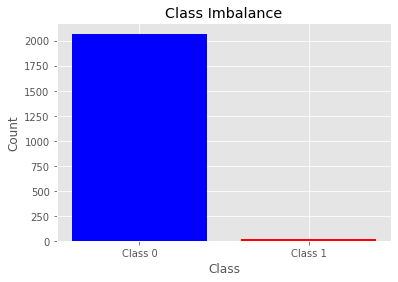

In [121]:
print(f'X\'s shape: {X.shape} y\'s shape: {y.shape}')
num_class0 = len(y[y['Label'] == 0])
num_class1 = len(y[y['Label'] == 1])
plt.bar([0, 1], [num_class0, num_class1], color=['blue', 'red'])
plt.xlabel('Class')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()

In [137]:
# Splitting up the data in test and train
print(np.sum(y[y == 1]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
print(y_train, y_test)

# Classifier
print(np.all(y_train) == 0)
print(np.all(y_test) == 0)
# clf = GaussianNB(var_smoothing=1e3)
clf = SGDClassifier(loss='hinge', penalty='l2',
	alpha=1e-6, random_state=42,
	max_iter=50, tol=None)
class_weight = {0 : 0.2, 1 : 0.8}
# clf = svm.SVC()
# Fitting our model to data
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

text_file = open("Results_unbalanced_SVM.txt", "w")
text_file.write(str(metrics.classification_report(y_test, y_pred)))
text_file.write(str(metrics.confusion_matrix(y_test, y_pred)))
text_file.close()

Label    14.0
dtype: float64
      Label
3477      0
709       0
3679      0
3208      0
3417      0
...     ...
3605      0
2580      0
2643      0
2937      0
2095      0

[1458 rows x 1 columns]       Label
3493      0
2042      0
3067      0
2370      0
3936      0
...     ...
1909      0
3853      0
136       0
2177      0
1054      0

[625 rows x 1 columns]
True
True
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       618
           1       0.43      0.43      0.43         7

    accuracy                           0.99       625
   macro avg       0.71      0.71      0.71       625
weighted avg       0.99      0.99      0.99       625

[[614   4]
 [  4   3]]


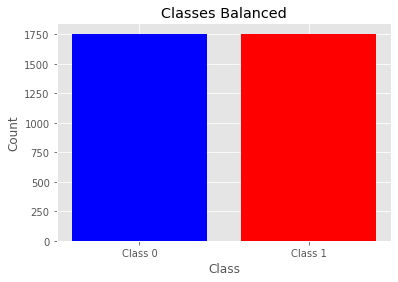

In [88]:
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train)
# X_test, y_test = sm.fit_resample(X_test, y_test)
num_class0 = len(y_train[y_train['Label'] == 0])
num_class1 = len(y_train[y_train['Label'] == 1])
# print(y_train)
# print(f'X\'s shape: {X_train.shape} y\'s shape: {y_train.shape}')
plt.bar([0, 1], [num_class0, num_class1], color=['blue', 'red'])
plt.xlabel('Class')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.ylabel('Count')
plt.title('Classes Balanced')
plt.show()

In [89]:
# Fitting our model to data
clf = clf.fit(X_train, y_train)

# X_test = scaler.transform(X_test)
# X_test = np.where(np.isfinite(X_test), X_test, 0)
# X_test = norm.transform(X_test)

y_pred = clf.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

text_file = open("Results_balanced_SVM.txt", "w")
text_file.write(str(metrics.classification_report(y_test, y_pred)))
text_file.write(str(metrics.confusion_matrix(y_test, y_pred)))
text_file.close()

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       313
           1       0.00      0.00      0.00         0

    accuracy                           0.98       313
   macro avg       0.50      0.49      0.49       313
weighted avg       1.00      0.98      0.99       313

[[306   7]
 [  0   0]]


In [138]:
# defining parameter range 
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
 ] 
  
grid = GridSearchCV(SVC(class_weight = {0 : 0.2, 1 : 0.8}), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .............................C=1, kernel=linear; total time=   0.0s
[CV 2/5] END .............................C=1, kernel=linear; total time=   0.0s
[CV 3/5] END .............................C=1, kernel=linear; total time=   0.0s
[CV 4/5] END .............................C=1, kernel=linear; total time=   0.0s
[CV 5/5] END .............................C=1, kernel=linear; total time=   0.0s
[CV 1/5] END ............................C=10, kernel=linear; total time=   0.0s
[CV 2/5] END ............................C=10, kernel=linear; total time=   0.0s
[CV 3/5] END ............................C=10, kernel=linear; total time=   0.0s
[CV 4/5] END ............................C=10, kernel=linear; total time=   0.0s
[CV 5/5] END ............................C=10, kernel=linear; total time=   0.0s
[CV 1/5] END ...........................C=100, kernel=linear; total time=   0.0s
[CV 2/5] END ...........................C=100, 

GridSearchCV(estimator=SVC(class_weight={0: 0.2, 1: 0.8}),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']}],
             verbose=3)

In [139]:
# print best parameter after tuning 
print(grid.best_params_)

X_sample = []
grid_predictions = grid.predict(X_test)
# p = np.array(clf.decision_function([grid_predictions]))
# print(p)
# print classification report 
print(metrics.classification_report(y_test, grid_predictions))

{'C': 10, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       618
           1       0.50      0.29      0.36         7

    accuracy                           0.99       625
   macro avg       0.75      0.64      0.68       625
weighted avg       0.99      0.99      0.99       625

